## Setup and Imports

In [4]:
# Import required libraries
import numpy as np # Numerical computations
import networkx as nx # Network analysis
import matplotlib.pyplot as plt # Plotting
import pandas as pd # Data manipulation
from tqdm.notebook import tqdm # Progress bars
import random # Random number generation
from collections import Counter # Counting hashable objects

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print(f"NetworkX version: {nx.__version__}")

NetworkX version: 3.5


# Part 1: IMDB Network Analysis

In this part, I will analyze the IMDB actor-movie network, which is a bipartite network where actors are connected to the movies they appeared in. I will explore projections, assortativity, and the friendship paradox.

In [ ]:
# Load the bipartite actor-movie network

file_path = "actors_movies.edges.gz"

# Read the edge list
G_bipartite = nx.read_edgelist(file_path)


print(f"  Total nodes: {G_bipartite.number_of_nodes()}")
print(f"  Total edges: {G_bipartite.number_of_edges()}")
print(f"\nFirst few edges (actor-movie pairs):")
print(list(G_bipartite.edges())[:5])

  Total nodes: 563443
  Total edges: 921160

First few edges (actor-movie pairs):
[('tt0095445', 'nm0000693'), ('tt0095445', 'nm0001278'), ('tt0095445', 'nm0810488'), ('nm0000693', 'tt0114367'), ('nm0000693', 'tt0097737')]


### Separate the nodes into actor nodes and movie nodes

In [6]:
# Separate nodes into actors and movies

movie_nodes = [node for node in G_bipartite.nodes() if node.startswith('tt')]
actor_nodes = [node for node in G_bipartite.nodes() if not node.startswith('tt')]


print(f"  Movie nodes: {len(movie_nodes)}")
print(f"  Actor nodes: {len(actor_nodes)}")
print(f"  Total: {len(movie_nodes) + len(actor_nodes)}")


  Movie nodes: 310444
  Actor nodes: 252999
  Total: 563443


### Create the projected graph where two actors are connected if they appeared in the same movie.

This transforms the bipartite network into a unipartite (single-type) actor collaboration network.

In [7]:
# NetworkX has a built-in function for bipartite projection
from networkx.algorithms import bipartite

# Project onto actor nodes only. This creates edges between actors who share at least one movie
G_actors = bipartite.projected_graph(G_bipartite, actor_nodes)

# Basic stats
print(f"  Nodes (actors): {G_actors.number_of_nodes()}")
print(f"  Edges (co-appearances): {G_actors.number_of_edges()}")
print(f"  Average degree: {2 * G_actors.number_of_edges() / G_actors.number_of_nodes():.2f}")


  Nodes (actors): 252999
  Edges (co-appearances): 1015187
  Average degree: 8.03


In [8]:
nx.is_connected(G_actors)

True

### Determine if the actor-actor network displays degree assortativity

Assortativity refers to the tendency of nodes in a network to connect to other nodes that are similar (or dissimilar) to themselves in some way. In the context of degree assortativity, we look at whether high-degree nodes tend to connect to other high-degree nodes (assortative mixing) or to low-degree nodes (disassortative mixing).

In [9]:
# Calculate degree assortativity coefficient
# This measures the correlation between degrees of connected nodes
assortativity = nx.degree_assortativity_coefficient(G_actors)

print(f"Degree Assortativity Coefficient: {assortativity:.4f}")



Degree Assortativity Coefficient: 0.2963


The network shows positive assortativity.This means highly connected actors collaborate with other highly connected actors.

Lets dig deep into...

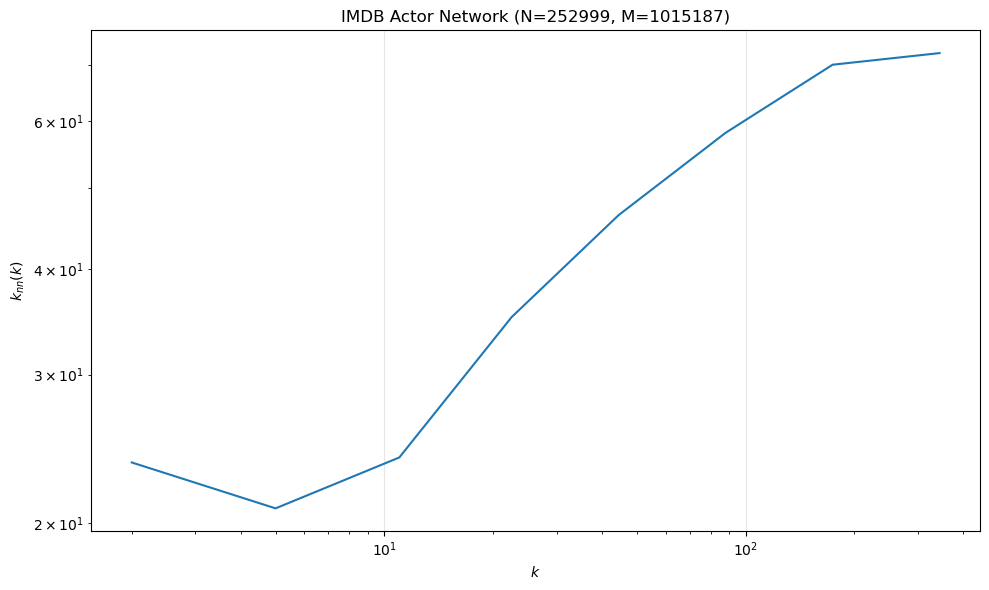

In [10]:
import seaborn as sns

# Compute degree sequence and average degree of neighbors
k_nn = nx.average_neighbor_degree(G_actors)
node_degrees = dict(G_actors.degree())

# Make it into a DataFrame for easier plotting
xs = np.array([node_degrees[node] for node in k_nn])
ys = np.array([k_nn[node] for node in k_nn])
df_knn_k = pd.DataFrame({"k": xs, "k_nn": ys}).sort_values("k")

# Bin the degree in logspace
bins = np.logspace(np.log10(1), np.log10(max(xs)+1), 10)
bins = np.unique(bins.astype(int))
df_knn_k.loc[:, 'k_bin'] = pd.cut(df_knn_k.k, bins, right=False)
df_knn_k.loc[:, 'midbin'] = df_knn_k.k_bin.apply(lambda x: x.mid).astype(float)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_knn_k, x='midbin', y='k_nn', estimator='mean', errorbar=None)

plt.title(f"IMDB Actor Network (N={G_actors.number_of_nodes()}, M={G_actors.number_of_edges()})")
plt.xlabel("$k$")
plt.ylabel(r"$k_{nn}(k)$")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The network exhibits a positive associativity ("rich-get-richer")  pattern, but only after actors reach a threshold of ~10 collaborations. Below this there is a slight disassortativity. One possible reason can be that less experienced actors benefit from working with more established talent.

### Does the friendship paradox occur in this network? What is the percentage of nodes whose degree is smaller than the average of their neighbors’ degree?

The friendship paradox states that, on average, our friends have more friends than we do. This paradox can be quantified by comparing the average degree of nodes, $<k>$, against the average degree of the neighbor, $<k_{nn}>$.

In [11]:
def check_friendship_paradox(G):
    """Return (avg_degree, avg_neighbor_degree, n_nodes_smaller, fraction_smaller)."""
    node_degrees = dict(G.degree())
    degs = np.fromiter(node_degrees.values(), dtype=float)
    avg_degree = degs.mean()

    neigh_deg = nx.average_neighbor_degree(G)
    neigh_vals = np.fromiter(neigh_deg.values(), dtype=float)
    avg_neighbor_degree = neigh_vals.mean()

    n_nodes_smaller = sum(1 for n in G.nodes() if node_degrees[n] < neigh_deg[n])
    fraction_smaller = n_nodes_smaller / G.number_of_nodes()

    return avg_degree, avg_neighbor_degree, n_nodes_smaller, fraction_smaller


# Example usage on the actor projection
avg_k, avg_knn, n_smaller, frac_smaller = check_friendship_paradox(G_actors)
print(f"Average degree <k>: {avg_k:.2f}")
print(f"Average neighbor degree <k_nn>: {avg_knn:.2f}")
print(f"Nodes with k < avg neighbor degree: {n_smaller} / {G_actors.number_of_nodes()} ({frac_smaller*100:.2f}%)")

Average degree <k>: 8.03
Average neighbor degree <k_nn>: 24.33
Nodes with k < avg neighbor degree: 227905 / 252999 (90.08%)


Insights: The network exhibit the friendship paradox. On average, actors' co-stars have more co-stars than they do.On average, actors' co-stars have more co-stars than they do. About 90% of nodes whose degree is smaller than the average of their neighbors’ degree

# Part 2: Network Attack Strategies

I will now analyze network robustness by implementing different attack strategies on the yeast protein interaction network. Network robustness refers to a network's ability to maintain its structure and function when nodes are removed. In real life, networks can fail in different ways:  

1. Random failures: routers breaking down randomly, people getting sick.
2. Targeted attacks: deliberately attacking critical infrastructure, removing key proteins -

In [ ]:
## # Load the yeast protein interaction network
file_path = "bio-yeast-protein-inter.edges"

# Load as undirected graph because protein interactions are mutual
G_yeast = nx.read_edgelist(file_path, create_using=nx.Graph)

print(f"Original network:")
print(f"  Nodes: {G_yeast.number_of_nodes()}")
print(f"  Edges: {G_yeast.number_of_edges()}")

# Remove self-loops becasue a protein connecting to itself doesn't make biological sense
self_loops = list(nx.selfloop_edges(G_yeast))
G_yeast.remove_edges_from(self_loops)
print(f"\nRemoved {len(self_loops)} self-loop edges")

# Extract the largest connected component (LCC)
# We focus on this because disconnected components can't interact
largest_cc = max(nx.connected_components(G_yeast), key=len)
G_yeast = G_yeast.subgraph(largest_cc).copy()

print(f"\nLCC:")
print(f"  Nodes: {G_yeast.number_of_nodes()}")
print(f"  Edges: {G_yeast.number_of_edges()}")
print(f"  Average degree: {2 * G_yeast.number_of_edges() / G_yeast.number_of_nodes():.2f}")

Original network:
  Nodes: 1870
  Edges: 2277

Removed 74 self-loop edges

LCC:
  Nodes: 1458
  Edges: 1948
  Average degree: 2.67


### Hypothesis


I will deploy following 4 network attack strategies:

1. The random attack should be least disruptive initially, as it's equally likely to remove peripheral or central nodes. The network should remain connected longer under random failures.
2. The random walk attack should be moderately effective. It has a bias toward high-degree nodes (since random walks are more likely to visit them) but less extreme than the degree-based attack. It should perform better than random but worse than targeted degree-based attack.
3. Degree-based attack (removing high-degree nodes first) to be the most disruptive. This is because removing hubs should quickly fragment the network.
4. The reverse degree attack (low-to-high) should be ineffective initially, as removing low-degree nodes (leaves) doesn't disconnect the network much. However, as we remove more nodes, we eventually reach the hubs.

This relates to the concepts of network robustness and vulnerability as real-world networks are often robust to random failures but vulnerable to targeted attacks on hubs.


### Implementing attack strategies

In [13]:
# Helpfer functions
def get_lcc_size(G):
    """
    Get the size of the largest connected component.
    Returns 0 if graph is empty.
    """
    if G.number_of_nodes() == 0:
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)

def remove_isolated_nodes(G):
    """
    Remove all nodes with degree 0 (isolated nodes).
    These nodes don't contribute to network connectivity.
    """
    isolated = list(nx.isolates(G))
    G.remove_nodes_from(isolated)
    return len(isolated)

In [14]:
def random_walk_attack(G, seed=42):
    """
    Random walk attack: remove nodes by performing a random walk.
    
    Algorithm:
    1. Pick a random starting node and remove it
    2. Move to a random neighbor of the removed node
    3. Remove that neighbor
    4. Repeat step 2-3
    5. If no neighbors exist, pick a random node from the network
    
    This attack has a bias toward high-degree nodes (they're visited more often
    in random walks) but is less deterministic than degree-based attack.
    """
    G_copy = G.copy()
    np.random.seed(seed)
    
    initial_size = G_copy.number_of_nodes()
    lcc_sizes = [get_lcc_size(G_copy)]  # Initial LCC size
    
    # Pick initial node randomly
    current_node = np.random.choice(list(G_copy.nodes()))
    
    while G_copy.number_of_nodes() > 0:
        # Get neighbors before removing the node
        neighbors = list(G_copy.neighbors(current_node))
        
        # Remove current node
        G_copy.remove_node(current_node)
        
        # Remove isolated nodes
        remove_isolated_nodes(G_copy)
        
        # Record LCC size
        lcc_sizes.append(get_lcc_size(G_copy))
        
        # If network is empty, stop
        if G_copy.number_of_nodes() == 0:
            break
        
        # Select next node
        # Filter out neighbors that were removed (isolated or the node itself)
        valid_neighbors = [n for n in neighbors if n in G_copy]
        
        if valid_neighbors:
            # Move to a random neighbor
            current_node = np.random.choice(valid_neighbors)
        else:
            # No valid neighbors: pick a random node from a random existing node's neighbors
            # As specified in the assignment
            random_node = np.random.choice(list(G_copy.nodes()))
            random_node_neighbors = list(G_copy.neighbors(random_node))
            
            if random_node_neighbors:
                current_node = np.random.choice(random_node_neighbors)
            else:
                # If even that has no neighbors, just pick any random node
                current_node = random_node
    
    return lcc_sizes


In [15]:
def random_attack(G, seed=42):
    """
    Random attack: remove nodes uniformly at random.
    This simulates random failures (e.g., hardware failures, random errors).
    """
    G_copy = G.copy()
    np.random.seed(seed)
    
    initial_size = G_copy.number_of_nodes()
    lcc_sizes = [get_lcc_size(G_copy)]  # Initial LCC size
    
    while G_copy.number_of_nodes() > 0:
        # Pick a random node
        node = np.random.choice(list(G_copy.nodes()))
        
        # Remove it
        G_copy.remove_node(node)
        
        # Remove isolated nodes
        remove_isolated_nodes(G_copy)
        
        # Record LCC size
        lcc_sizes.append(get_lcc_size(G_copy))
    
    return lcc_sizes


In [16]:
def degree_attack(G, reverse=False):
    """
    Degree-based attack: remove nodes based on their degree.
    Parameters:
    - reverse: if False, remove highest degree first (most disruptive)
               if True, remove lowest degree first (least disruptive)
    
    This simulates targeted attacks on important nodes (hubs).
    """
    G_copy = G.copy()
    
    initial_size = G_copy.number_of_nodes()
    lcc_sizes = [get_lcc_size(G_copy)]  # Initial LCC size
    
    while G_copy.number_of_nodes() > 0:
        # Get node degrees
        degrees = dict(G_copy.degree())
        
        # Sort nodes by degree
        if reverse:
            # Remove lowest degree first
            node = min(degrees, key=degrees.get)
        else:
            # Remove highest degree first
            node = max(degrees, key=degrees.get)
        
        # Remove the node
        G_copy.remove_node(node)
        
        # Remove isolated nodes
        remove_isolated_nodes(G_copy)
        
        # Record LCC size
        lcc_sizes.append(get_lcc_size(G_copy))
    
    return lcc_sizes


### Running attack simulations (experiments)

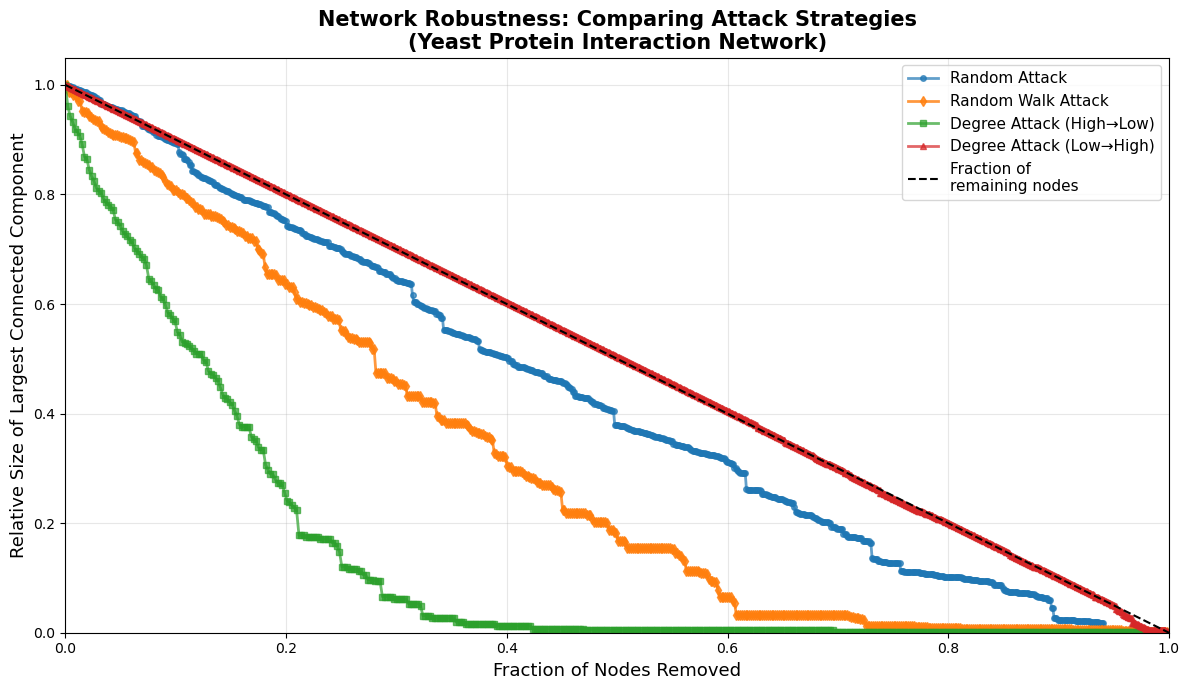

In [18]:
# Random attacks
lcc_random = random_attack(G_yeast, seed=42)

# Random-walk attack
lcc_random_walk = random_walk_attack(G_yeast, seed=42)

# Degree-based attacks
lcc_degree_high = degree_attack(G_yeast, reverse=False)

# Reverse degree-based attacks
lcc_degree_low = degree_attack(G_yeast, reverse=True)

# Visualization of attack results
initial_size = G_yeast.number_of_nodes()

# Convert to relative sizes (fraction of original network)
lcc_random_norm = [size / initial_size for size in lcc_random]
lcc_random_walk_norm = [size / initial_size for size in lcc_random_walk]
lcc_degree_high_norm = [size / initial_size for size in lcc_degree_high]
lcc_degree_low_norm = [size / initial_size for size in lcc_degree_low]

# Create x-axis (fraction of nodes removed)
x_random = np.linspace(0, 1, len(lcc_random_norm))
x_random_walk = np.linspace(0, 1, len(lcc_random_walk_norm))
x_degree_high = np.linspace(0, 1, len(lcc_degree_high_norm))
x_degree_low = np.linspace(0, 1, len(lcc_degree_low_norm))

# Plot
plt.figure(figsize=(12, 7))
ax = plt.gca()

ax.plot(x_random, lcc_random_norm, 'o-', label='Random Attack',
         linewidth=2, markersize=4, alpha=0.7)
ax.plot(x_random_walk, lcc_random_walk_norm, 'd-', label='Random Walk Attack',
         linewidth=2, markersize=5, alpha=0.8)
ax.plot(x_degree_high, lcc_degree_high_norm, 's-', label='Degree Attack (High→Low)',
         linewidth=2, markersize=4, alpha=0.7)
ax.plot(x_degree_low, lcc_degree_low_norm, '^-', label='Degree Attack (Low→High)',
         linewidth=2, markersize=4, alpha=0.7)

# Fraction of remaining nodes (diagonal line from 1 to 0 across fraction-removed axis)
ax.plot([0, 1], [1, 0], "k--", label="Fraction of\nremaining nodes")

ax.set_xlabel('Fraction of Nodes Removed', fontsize=13)
ax.set_ylabel('Relative Size of Largest Connected Component', fontsize=13)
ax.set_title('Network Robustness: Comparing Attack Strategies\n(Yeast Protein Interaction Network)',
             fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()


Insights: The degree attack disrupts the network fastest (most disruptive), causing rapid fragmentation with only 20-30% node removal. This confirms that scale-free networks are vulnerable to targeted hub attacks due to their preferential attachment structure, where a few highly connected nodes maintain overall connectivity. The random walk attack demonstrates intermediate effectiveness, exploiting the probabilistic tendency to traverse high-degree nodes, which makes it more disruptive than purely random selection while remaining less targeted than explicit degree-based attacks. On the other hand, random attack shows less effectiveness compared to the degree and random walk attacks, occasionally hitting hubs by chance, resulting in gradual linear decline. In comparison to above three, the inverse degree attack seems ineffective, overlapping with the baseline throughout. This is because removing peripheral nodes causes proportional shrinkage without fragmentation. This demonstrates network robustness to random failures,low-degree nodes contribute minimally to structural integrity, while hubs are critical failure points.

# Part 3: Fitness Model Implementation

The fitness model extends the Barabási-Albert (BA) preferential attachment model by assigning each node a "fitness" value that influences its attractiveness for new connections. In the standard BA model, attachment probability is proportional to degree alone. In the fitness model, it's proportional to degree × fitness.

Intution:  BA model says rich get richer (nodes with more connections get even more while fitness Model says the talented (fitness) and well-connected (degree) get richer

## Pre-Experiment Hypothesis

1. How would you expect the degree of the monitored nodes to grow as a function of time?

In the vanilla BA model, degree growth follows a power law, and all nodes grow at the same rate (proportional to their current degree). Early nodes (small index) always have more time to accumulate connections, so they end up with higher degree. In the fitness model, I expect high fitness nodes should grow faster than expected in BA model, even if they join later. On other hand, low fitness nodes should grow slower than expected, even if they join early. The first-mover advantage of early nodes should be reduced compared to BA. Finanlly I might see a late-joining high-fitness node eventually surpass an early-joining low-fitness node



2. Would you expect their evolution to differ from the one in the vanilla BA model?

Yes I do expected that network evolution difference compared to BA model. In BA model degree growth is purely time dependent: older nodes always win. However in fitness models degree growth will be dependent on both the time and its fitness value of node. 

### Implement a fitness model

In [1]:
def fitness_model(N, m, m0, fitness_scores, nodes_monitor, seed=None):
    """
    Implement the fitness model (extension of Barabási-Albert model).
    
    Parameters:
    -----------
    N : int
        Final number of nodes in the network
    m : int
        Number of edges to attach from each new node
    m0 : int
        Size of initial complete graph (clique)
    fitness_scores : list
        Fitness value for each node (fitness_scores[i] = fitness of node i)
    nodes_monitor : list
        List of node IDs to track throughout evolution
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    G : networkx.Graph
        The generated network
    G_hist : pandas.DataFrame
        Evolution history of monitored nodes with columns:
        - node_id: ID of the node
        - fitness: fitness of the node
        - t_creation: step when node was added
        - t_current: current step
        - degree: degree of node at current step
    """
    # Set random seed
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize graph with a complete graph of m0 nodes
    G = nx.complete_graph(m0)
    
    # History tracking for monitored nodes
    history = []
    
    # Helper function to record state
    def record_state(current_step):
        """Record the state of monitored nodes at current step"""
        for node in nodes_monitor:
            if node in G:  # Only record if node exists
                history.append({
                    'node_id': node,
                    'fitness': fitness_scores[node],
                    't_creation': node,  # In our model, node i is created at step i
                    't_current': current_step,
                    'degree': G.degree(node)
                })
    
    # Record initial state (after m0 nodes)
    record_state(m0)
    
    # Add remaining nodes one by one
    for i in range(m0, N):
        # Calculate attachment probabilities
        # P(attach to node j) ∝ degree(j) × fitness(j)
        
        nodes_list = list(G.nodes())
        degrees = np.array([G.degree(node) for node in nodes_list])
        fitnesses = np.array([fitness_scores[node] for node in nodes_list])
        
        # Attachment probability proportional to degree × fitness
        attachment_probs = degrees * fitnesses
        
        # Normalize to get probabilities
        attachment_probs = attachment_probs / attachment_probs.sum()
        
        # Select m nodes to connect to (without replacement)
        targets = np.random.choice(
            nodes_list, 
            size=m, 
            replace=False, 
            p=attachment_probs
        )
        
        # Add new node i and connect to selected targets
        G.add_node(i)
        for target in targets:
            G.add_edge(i, target)
        
        # Record state after adding this node
        record_state(i)
    
    # Convert history to DataFrame
    G_hist = pd.DataFrame(history)
    
    return G, G_hist


### Run Multiple Simulations (50 iterations)

In [19]:
# Parameters 
N = 2000
m = 5
m0 = 5
nodes_monitor = [100, 101, 102, 103, 104, 105, 200, 201, 202, 203, 204, 205]

# Load fitness scores 
fitness_scores = np.loadtxt("fitness_scores.txt")



# For BA model, fitness is constant (equal for all nodes)
# Setting all fitness to 1.0 makes it equivalent to standard BA
fitness_scores_ba = np.ones(N)


# Storage for all histories
all_hist_fitness = []
all_hist_ba = []

# Run 50 iterations
n_iterations = 50
for i in tqdm(range(n_iterations), desc="Simulations"):
    # Different seed for each iteration
    seed = 42 + i
    
    # Generate fitness model
    G_fit, hist_fit = fitness_model(N, m, m0, fitness_scores, nodes_monitor, seed=seed)
    hist_fit['iteration'] = i
    hist_fit['model'] = 'Fitness'
    all_hist_fitness.append(hist_fit)
    
    # Generate BA model (fitness model with constant fitness)
    G_ba, hist_ba = fitness_model(N, m, m0, fitness_scores_ba, nodes_monitor, seed=seed)
    hist_ba['iteration'] = i
    hist_ba['model'] = 'BA'
    all_hist_ba.append(hist_ba)

# Concatenate all histories
df_fitness = pd.concat(all_hist_fitness, ignore_index=True)
df_ba = pd.concat(all_hist_ba, ignore_index=True)
df_all = pd.concat([df_fitness, df_ba], ignore_index=True)



Simulations:   0%|          | 0/50 [00:00<?, ?it/s]

### Analysis

In [20]:
# Create relative time variable: time since node creation
df_all['rel_t'] = df_all['t_current'] - df_all['t_creation']

# For better visualization, separate nodes by their fitness level
# Get fitness of each monitored node
node_fitness = {node: fitness_scores[node] for node in nodes_monitor}


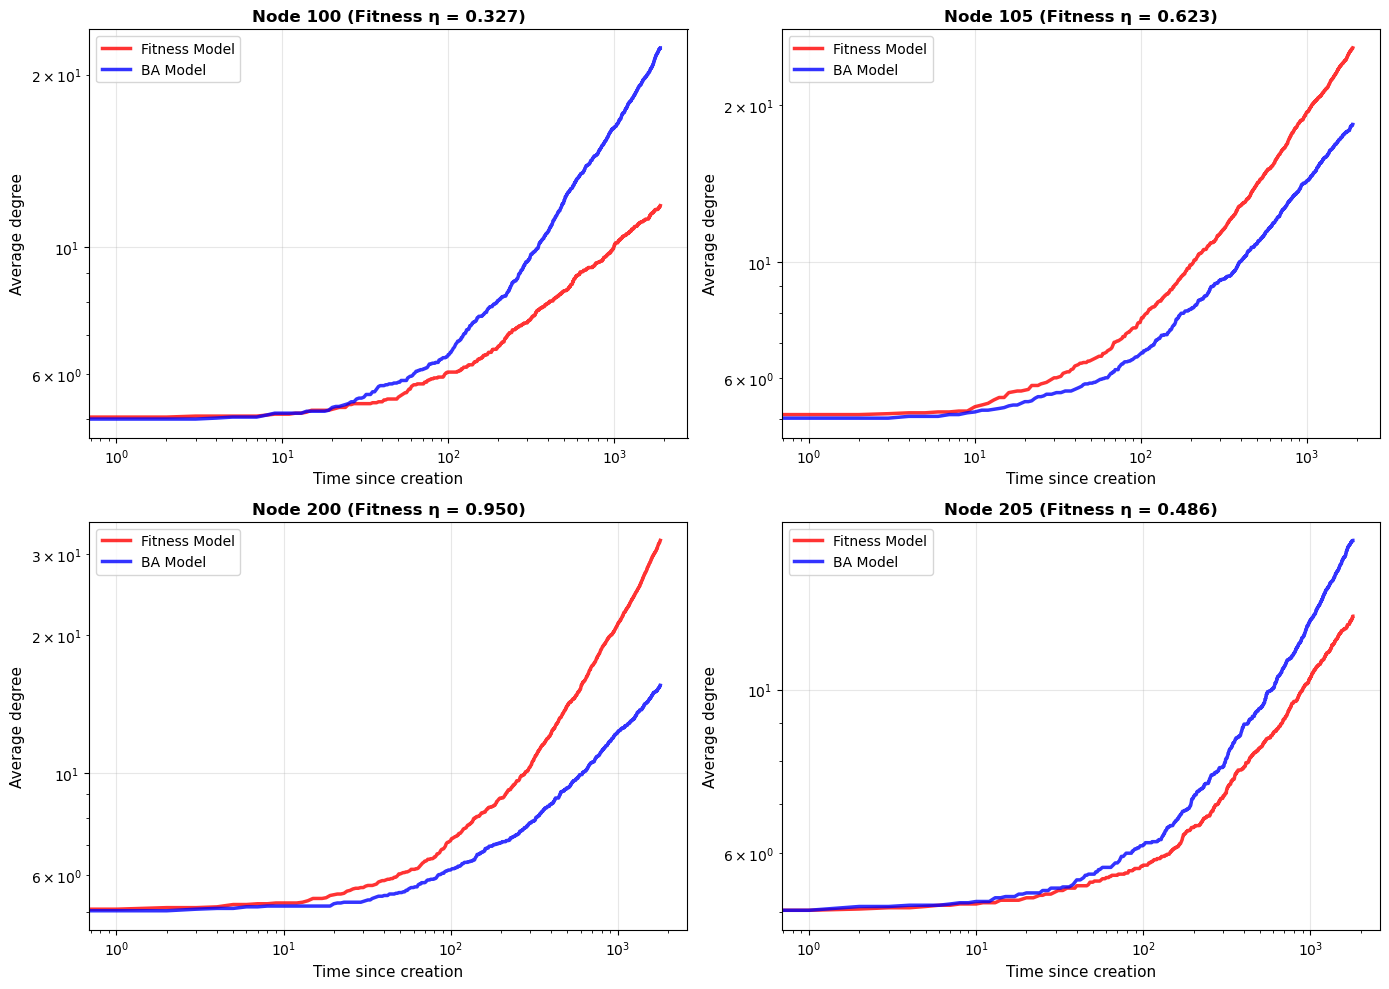

In [22]:
# Pick a few specific nodes to show direct comparison
comparison_nodes = [100, 105, 200, 205]  # Mix of high and low fitness, early and late

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, node in enumerate(comparison_nodes):
    ax = axes[idx]
    
    # Get data for this node in both models
    fitness_data = df_all[(df_all['node_id'] == node) & (df_all['model'] == 'Fitness')]
    ba_data = df_all[(df_all['node_id'] == node) & (df_all['model'] == 'BA')]
    
    # Average over iterations
    fit_avg = fitness_data.groupby('rel_t')['degree'].mean()
    ba_avg = ba_data.groupby('rel_t')['degree'].mean()
    
    ax.plot(fit_avg.index, fit_avg.values, 'r-', linewidth=2.5, label='Fitness Model', alpha=0.8)
    ax.plot(ba_avg.index, ba_avg.values, 'b-', linewidth=2.5, label='BA Model', alpha=0.8)
    
    ax.set_xlabel('Time since creation', fontsize=11)
    ax.set_ylabel('Average degree', fontsize=11)
    ax.set_title(f'Node {node} (Fitness η = {fitness_scores[node]:.3f})', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.tight_layout()
plt.show()



Observation:
High-fitness nodes grow faster in the Fitness model compared to BA.
Low-fitness nodes grow slower in the Fitness model compared to BA.
This demonstrates how fitness modulates the preferential attachment mechanism.

### Interpretation of Results

The results strongly support our initial hypothesis. The degree evolution patterns differ fundamentally between the BA and fitness models, and fitness enables late-joining high-fitness nodes to overtake early-joining low-fitness nodes.

Main Findings:

1. High-fitness nodes grow faster than BA predictions: Nodes 105 (η=0.623) and 200 (η=0.950) both demonstrate accelerated growth compared to their BA baselines. Node 200 shows the most dramatic effect: despite being the same age as Node 205 in both models, its high fitness causes it to achieve approximately 32 degrees by t≈1800, compared to only 15 degrees predicted by the BA model: a 2.1× enhancement. Similarly, Node 105 reaches approximately 25 degrees versus 18 in the BA model, representing a 39% increase. This confirms that high fitness acts as a multiplicative growth factor, amplifying the preferential attachment mechanism.

2. Low-fitness nodes grow slower than BA predictions: Node 100 (η=0.327) exhibits strong growth suppression. While the BA model predicts approximately 22 degrees at t≈1800, the fitness model yields only 12 degrees: a 45% reduction. The gap between fitness and BA trajectories widens over time, indicating that low fitness creates a compounding disadvantage. This demonstrates that fitness penalties accumulate as nodes with poor intrinsic appeal consistently lose in competition for new connections.

3. Late-joining high-fitness nodes overtake early-joining low-fitness nodes: The most striking validation of the hypothesis occurs when comparing Nodes 100 and 200. Node 100 joins at t=100 with fitness η=0.327, while Node 200 joins 100 steps later (t=200) with fitness η=0.950. Despite this age disadvantage, Node 200's trajectory crosses above Node 100's around t≈200-300 (approximately 100-200 steps after Node 200's entry). By the end of the simulation, Node 200 achieves roughly 2.7× higher degree than Node 100 (32 vs 12), completely reversing the first-mover advantage that would exist in the vanilla BA model.

4. The fitness effect is non-uniform and fitness-dependent: Node 205 (η=0.486) provides a near-neutral control case. Its fitness of 0.486 is close to the expected mean of a uniform [0,1] distribution (0.5), and accordingly, its fitness and BA trajectories remain nearly identical throughout the simulation. This demonstrates that the fitness effect scales with distance from neutrality—extreme fitness values create strong effects, while moderate fitness values produce minimal deviation from BA behavior.

5. Growth mechanisms differ fundamentally between models: In the BA model, all four nodes show similar growth rates when adjusted for age, with trajectories differing primarily by a temporal offset. The blue lines (BA) maintain roughly parallel slopes on the log-log scale, indicating that degree growth follows k(t) ∝ √t regardless of node identity. In contrast, the fitness model produces divergent trajectories with slopes that vary systematically with fitness values. High-fitness nodes show steeper slopes (faster growth rates), while low-fitness nodes show flatter slopes, proving that fitness modulates the attachment probability beyond simple degree-based preferential attachment.

Interpretation:

The fitness model reveals that network growth is governed by the interplay of two competing forces: temporal advantage (age) and intrinsic quality (fitness). The results demonstrate three regimes:

1. High fitness dominates age: Node 200's victory over Node 100 shows that sufficient fitness advantage can overcome substantial age disadvantage
2. Moderate fitness provides modest advantage: Node 105's 39% improvement over BA shows fitness helps but doesn't radically alter trajectories when values are moderate
3. Low fitness creates compounding penalties: Node 100's 45% reduction shows that poor fitness creates accelerating disadvantage over time

This has important implications for real-world networks. In systems like academic citations, the fitness model explains how groundbreaking recent papers can accumulate citations faster than older mediocre work. In the web, it explains how Google (founded 1998) overtook earlier search engines like AltaVista (1995) and Yahoo (1994). The model suggests that in competitive growing networks, entry timing matters less than intrinsic quality—provided the quality difference is substantial enough to overcome the head start of incumbents.

In conclusion, while the BA model predicts that older nodes always dominate, the fitness model shows that quality can trump timing. First-mover advantage exists but is not insurmountable. Networks reward fitness, and late entrants with superior fitness can achieve dominance despite arriving after the market has formed.